<a href="https://colab.research.google.com/github/aishaa205/Human_Activity_Recognition/blob/main/Vit_Gait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
!pip install -qq transformers accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.1 MB/s eta 0:00:00


In [ ]:
import random
import os

from google.colab import drive
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, pipeline
import evaluate
import seaborn as sns

pd.options.mode.chained_assignment = None # Turn off some annoying pandas warning

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (79.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# Setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setting seed for reproducible results

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#loading data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set our own "Data" Folder path

DATASET_PATH = r"/content/drive/MyDrive/Gait_classifocation/walk_or_run.zip".replace(" ", "\ ") # Escaping White-spaces
!cp $DATASET_PATH .

In [ ]:
!unzip -qq walk_or_run.zip

In [ ]:
!tree -d walk_or_run

walk_or_run
├── test
│   ├── run
│   └── walk
└── train
    ├── run
    └── walk

6 directories


In [ ]:
def load_images(path):
  images = []

  for split in os.listdir(path):
    split_path = os.path.join(path, split)

    for label in os.listdir(split_path):
      label_path = os.path.join(split_path, label)

      for image in os.listdir(label_path):
        img_path = os.path.join(label_path, image)

        img = Image.open(img_path)

        images.append({
            "image": img,
            "label": label,
            "split": split
          })

  return images

In [ ]:
PATH = 'walk_or_run'
images = load_images(PATH)

## convert images from RGBA to RGB (png to jpg)

In [ ]:
from PIL import Image
import os

def convert_folder_png_to_jpeg(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".png"):
            png_path = os.path.join(input_folder, filename)
            img = Image.open(png_path)
            jpeg_path = os.path.join(output_folder, filename.replace(".png", ".jpg"))
            img.convert("RGB").save(jpeg_path, "JPEG")

# Example usage:
input_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run/test/run"
output_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run_jpg/test/run"
convert_folder_png_to_jpeg(input_folder, output_folder)

In [ ]:
from PIL import Image
import os

def convert_folder_png_to_jpeg(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".png"):
            png_path = os.path.join(input_folder, filename)
            img = Image.open(png_path)
            jpeg_path = os.path.join(output_folder, filename.replace(".png", ".jpg"))
            img.convert("RGB").save(jpeg_path, "JPEG")

# Example usage:
input_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run/test/walk"
output_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run_jpg/test/walk"
convert_folder_png_to_jpeg(input_folder, output_folder)

In [ ]:
from PIL import Image
import os

def convert_folder_png_to_jpeg(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".png"):
            png_path = os.path.join(input_folder, filename)
            img = Image.open(png_path)
            jpeg_path = os.path.join(output_folder, filename.replace(".png", ".jpg"))
            img.convert("RGB").save(jpeg_path, "JPEG")

# Example usage:
input_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run/train/run"
output_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run_jpg/train/run"
convert_folder_png_to_jpeg(input_folder, output_folder)

In [ ]:
from PIL import Image
import os

def convert_folder_png_to_jpeg(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".png"):
            png_path = os.path.join(input_folder, filename)
            img = Image.open(png_path)
            jpeg_path = os.path.join(output_folder, filename.replace(".png", ".jpg"))
            img.convert("RGB").save(jpeg_path, "JPEG")

# Example usage:
input_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run/train/walk"
output_folder = "/content/drive/MyDrive/Gait_classifocation/walk_or_run_jpg/train/walk"
convert_folder_png_to_jpeg(input_folder, output_folder)

In [ ]:
PATH = '/content/drive/MyDrive/Gait_classifocation/walk_or_run_jpg'
images = load_images(PATH)

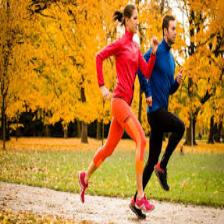

In [ ]:
images[20]['image']

In [ ]:
print(images[20]['image'])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7B2CDEA7DE10>


In [ ]:
print(images[20]['label'])

run


In [ ]:
df = pd.DataFrame(images)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   741 non-null    object
 1   label   741 non-null    object
 2   split   741 non-null    object
dtypes: object(3)
memory usage: 17.5+ KB


In [ ]:
df['label'].value_counts()

label
run     381
walk    360
Name: count, dtype: int64

In [ ]:
label2id = {"walk": 0, "run": 1}
id2label = {0: 'walk', 1: 'run'}
num_labels = 2

In [ ]:
# Getting numerical labels
df['labelid'] = df['label'].map(label2id)

# shuffling samples
df = df.sample(frac=1, random_state=SEED, ignore_index=True)

In [ ]:
df.split.value_counts()

split
train    600
test     141
Name: count, dtype: int64

In [ ]:
df.head()

,image,label,split,labelid
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,walk,test,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,walk,train,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,walk,train,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,run,train,1
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,walk,train,0


In [ ]:
df_train = df[df['split'] == 'train'].drop(columns=['split'])
df_test = df[df['split'] == 'test'].drop(columns=['split'])

In [ ]:
df_train['label'].value_counts()

label
walk    301
run     299
Name: count, dtype: int64

In [ ]:
df_test['label'].value_counts()

label
run     82
walk    59
Name: count, dtype: int64

#Load VIT

In [ ]:
MODEL_NAME = 'google/vit-base-patch16-224-in21k' # Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224

In [ ]:
model = ViTForImageClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, label2id=label2id, id2label=id2label)
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Define a PyTorch Dataset

class IntelImageClassificationDataset(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    image = self.df.iloc[index]['image']
    label = self.df.iloc[index]['labelid']

    inputs = processor(image, return_tensors='pt')
    inputs['pixel_values'] = inputs['pixel_values'].squeeze()
    inputs['labels'] = label

    return inputs

In [ ]:
train_set = IntelImageClassificationDataset(df=df_train)
test_set = IntelImageClassificationDataset(df=df_test)

In [ ]:
train_set[0]

{'pixel_values': tensor([[[-0.7882, -0.8431, -0.8745,  ..., -0.8902, -0.8510, -0.8196],
         [-0.7961, -0.8510, -0.8824,  ..., -0.9059, -0.8667, -0.8353],
         [-0.8118, -0.8667, -0.8980,  ..., -0.9294, -0.8980, -0.8745],
         ...,
         [-0.5529, -0.5451, -0.5451,  ..., -0.6314, -0.6235, -0.6157],
         [-0.5373, -0.5294, -0.5294,  ..., -0.6314, -0.6157, -0.6000],
         [-0.5216, -0.5216, -0.5216,  ..., -0.6235, -0.6078, -0.6000]],

        [[-0.7647, -0.8196, -0.8510,  ..., -0.8745, -0.8353, -0.8039],
         [-0.7725, -0.8275, -0.8588,  ..., -0.8902, -0.8510, -0.8196],
         [-0.7882, -0.8431, -0.8745,  ..., -0.9137, -0.8824, -0.8588],
         ...,
         [-0.5608, -0.5529, -0.5529,  ..., -0.5765, -0.5686, -0.5608],
         [-0.5451, -0.5373, -0.5373,  ..., -0.5765, -0.5608, -0.5451],
         [-0.5294, -0.5294, -0.5294,  ..., -0.5686, -0.5529, -0.5451]],

        [[-0.8353, -0.8902, -0.9216,  ..., -0.8980, -0.8588, -0.8275],
         [-0.8431, -0.8980, 

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# Model Fine-tuning

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)

    # NOTE: F1-Score is a better metric for imbalanced datasets
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids) # returns {'accuracy':float}

In [ ]:
training_args = TrainingArguments(
    output_dir="model",
    logging_dir="model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    fp16=True,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_set,
    eval_dataset=test_set,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.638900,0.589885,0.865248
2,0.534200,0.561670,0.872340


TrainOutput(global_step=10, training_loss=0.5865470409393311, metrics={'train_runtime': 3016.6113, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.003, 'total_flos': 9.29903875375104e+16, 'train_loss': 0.5865470409393311, 'epoch': 2.0})

#Model Evaluation

In [ ]:
# Evaluate Model on the Test set
results = trainer.evaluate(eval_dataset=test_set)

In [ ]:
results

{'eval_loss': 0.5616704821586609,
 'eval_accuracy': 0.8723404255319149,
 'eval_runtime': 110.9492,
 'eval_samples_per_second': 1.271,
 'eval_steps_per_second': 0.027,
 'epoch': 2.0}

In [ ]:
trainer.save_model('best_model')

In [ ]:
classifier = pipeline(task="image-classification", model="best_model", device=device)
preds = classifier(df_test['image'].to_list(), batch_size=8)

In [ ]:
targets = df_test['label'].to_list()
preds = [pred[0]['label'] for pred in preds]

In [ ]:
# Classification report

report = classification_report(targets, preds)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         run       0.90      0.88      0.89        82
        walk       0.84      0.86      0.85        59

    accuracy                           0.87       141
   macro avg       0.87      0.87      0.87       141
weighted avg       0.87      0.87      0.87       141



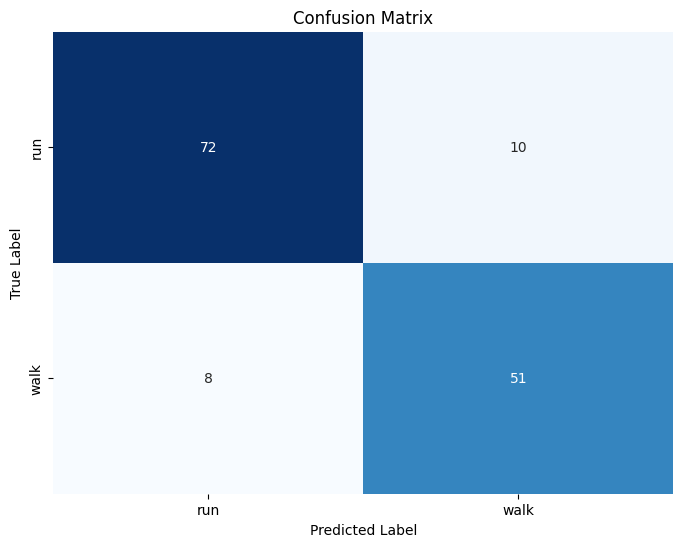

In [ ]:
# Confusion Matrix
cm = confusion_matrix(targets, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(targets), yticklabels=np.unique(preds))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
## Testing inference on a random online image
image_path_1= "/content/drive/MyDrive/Gait_classifocation/preson1.jpeg"
image_path_2="/content/drive/MyDrive/Gait_classifocation/preson2.jpeg"

img_1 = Image.open(image_path_1)
img_2 = Image.open(image_path_2)


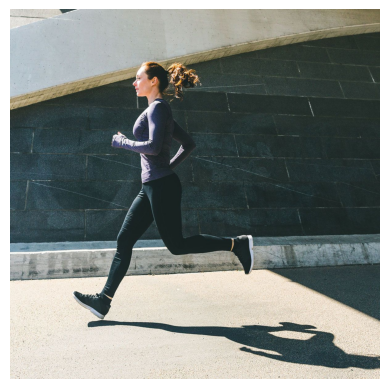

In [ ]:
import matplotlib.image as mpimg
import pprint


plt.imshow(img_2)
plt.axis('off')
plt.show()

In [ ]:
prediction = classifier(img_2)
pprint.pprint(prediction)

[{'label': 'run', 'score': 0.5615978240966797},
 {'label': 'walk', 'score': 0.4384021461009979}]


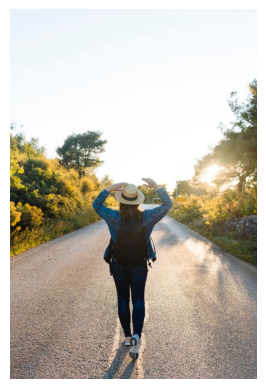

In [ ]:
plt.imshow(img_1)
plt.axis('off')
plt.show()

In [ ]:
prediction = classifier(img_1)
pprint.pprint(prediction)

[{'label': 'walk', 'score': 0.6421783566474915},
 {'label': 'run', 'score': 0.35782167315483093}]
